## Synthetic Splitgraph benchmarks

This notebook contains a series of benchmarks that generate some random data and test the time and space overhead of using
Splitgraph to manage the data over PostgreSQL.

In [1]:
import itertools
import random
from random import getrandbits

import pandas as pd
import seaborn as sns

from splitgraph.core.repository import Repository
from splitgraph.core.common import Tracer
from splitgraph.engine import ResultShape
from splitgraph.core.types import TableColumn

from psycopg2.sql import SQL, Identifier

import matplotlib.ticker as mtick
from matplotlib import pyplot as plt
%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (10,10)

import logging
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.WARNING)

BENCHMARK = Repository("splitgraph_test", "benchmark")

In [2]:
def generate_random_table(repository: Repository, table_name: str, size: int, create: bool = True,
                         start_key: int = 0):
    """
    Creates a table with an integer primary key, a string value and an integer value.
    """
    if create:
        repository.object_engine.create_table(
            repository.to_schema(),
            table_name,
            [TableColumn(1, "key", "integer", True),
             TableColumn(2, "value_1", "varchar", False),
             TableColumn(3, "value_2", "bigint", False),
            ],
        )
    repository.object_engine.run_sql_batch(
        SQL("INSERT INTO {} VALUES (%s, %s, %s)").format(Identifier(table_name)),
        [(i, "%0.2x" % getrandbits(32), random.randrange(1, 100000)) for i in range(start_key, start_key + size)],
        schema=repository.to_schema(),
    )

In [3]:
def benchmark_single(repository: Repository, size: int, query_iterations: int):
    """Perform various Splitgraph actions and record the time/space taken by them."""
    repository.delete()
    repository.objects.cleanup()
    repository.init()
    
    # We use the time taken by PostgreSQL to write the original table as a baseline.
    tracer = Tracer()
    generate_random_table(repository, table_name="test", size=size)
    tracer.log("table_creation")
    
    # Commit the table. Since this is a new table, Splitgraph will chunk it up instead of
    # performing change tracking.
    
    # We also want to target moderately large objects (each will be ~4MB in this case)
    # to decrease the overhead of handling multiple tiny objects (default configuration produces
    # objects of ~300KiB each).
    head = repository.commit(chunk_size=250000)
    tracer.log("commit_snap")
    
    # Now change tracking is enabled. Do another set of writes to calculate its overhead.
    generate_random_table(repository, table_name="test", create=False, start_key=size, size=size)
    tracer.log("insert_rows_change_tracking")
    
    # Discard all changes and time how long the checkout takes.
    repository.object_engine.discard_pending_changes(repository.to_schema())
    repository.uncheckout()
    
    tracer.log("uncheckout")
    head.checkout()
    tracer.log("checkout")
    
    # Check the sizes taken by the Splitgraph table and the PostgreSQL table
    postgres_size = repository.engine.run_sql("SELECT pg_total_relation_size(%s)",
                              ('"' + repository.to_schema() + '".test',),
                              return_shape=ResultShape.ONE_ONE)
    splitgraph_size = head.get_size()
    
    tracer.log("get_sizes")
    
    # Test the time taken by some sample queries with PostgreSQL vs layered querying
    # This is a very crude benchmark, since this is not real-world data or query load.
    
    # NB SQL injection, we trust the value of the `size` here but this shouldn't be run in anything serious.
    queries = [("SELECT AVG(value_2) FROM test", "select_all"),
               ("SELECT value_1 FROM test WHERE key = %s" % (size // 2), "select_by_key"),
               ("SELECT AVG(value_2) FROM test WHERE key BETWEEN %s AND %s" % (size // 4, size // 4 + 1000),
               "aggregate"),
               ("SELECT 1 FROM test WHERE value_1 = '00000000'", "select_by_value")]
    
    # First, run this with Postgres
    for query, name in queries:
        # Run the query once for warmup first
        repository.run_sql(query)
        for _ in range(query_iterations):
            repository.run_sql(query)
        tracer.log(name + "_pg")
    
    # Do an LQ checkout and try this again
    head.checkout(layered=True)
    tracer.log("lq_checkout")
    
    for query, name in queries:
        repository.run_sql(query)
        for _ in range(query_iterations):
            repository.run_sql(query)
        tracer.log(name + "_lq")

    return tracer, postgres_size, splitgraph_size

In [4]:
def benchmark_multiple(repository: Repository, size: int, iterations: int):
    """Perform multiple benchmark runs and return the averages"""
    result = []
    
    for _ in range(iterations):
        query_iterations = max(iterations, 20)
        tracer, pg_size, sg_size = benchmark_single(repository, size, query_iterations=query_iterations)
        
        durations = tracer.get_durations()
        
        subresult = []
        
        for e, ed in durations:
            # divide query durations by the amount of times they ran in this iteration
            if e.endswith("_pg") or e.endswith("_lq"):
                ed = ed / float(query_iterations)
                
            subresult.append((e, ed))
        
        subresult.append(("pg_size", pg_size))
        subresult.append(("sg_size", sg_size))
    
        result.append(subresult)
    
    # Average the result
    result_avg = []
    for rs in zip(*result):
        result_name = rs[0][0]
        result_values = [rr[1] for rr in rs]
        
        result_avg.append((result_name, sum(result_values) / float(len(result_values))))
    
    return result_avg

In [5]:
sizes_iterations = [
    (1000, 10),
    (5000, 10),
    (10000, 10),
    (50000, 3),
    (100000, 3),
    (500000, 3),
    (1000000, 3),
    (5000000, 1),
]

results = []

for size, iterations in sizes_iterations:
    print(f"Running size={size}, iterations={iterations}")
    results.append(benchmark_multiple(BENCHMARK, size=size, iterations=iterations))

Running size=1000, iterations=10


100%|██████████| 1/1 [00:00<00:00,  7.27objs/s]


Running size=5000, iterations=10


100%|██████████| 1/1 [00:00<00:00,  4.43objs/s]


Running size=10000, iterations=10


100%|██████████| 1/1 [00:00<00:00,  2.81objs/s]


Running size=50000, iterations=3


100%|██████████| 1/1 [00:01<00:00,  1.41s/objs]


Running size=100000, iterations=3


100%|██████████| 1/1 [00:02<00:00,  2.90s/objs]


Running size=500000, iterations=3


100%|██████████| 2/2 [00:01<00:00,  1.14obj/s, object=o3ccfc54c7...]


Running size=1000000, iterations=3


100%|██████████| 4/4 [00:04<00:00,  1.10s/obj, object=ofb172a6b3...]


Running size=5000000, iterations=1


100%|██████████| 20/20 [01:15<00:00,  3.78s/obj, object=o7022b61aa...]


In [6]:
results

[[('table_creation', 0.09536900000000001),
  ('commit_snap', 0.40631950000000006),
  ('insert_rows_change_tracking', 0.15949400000000002),
  ('uncheckout', 0.21024980000000001),
  ('checkout', 0.2823854),
  ('get_sizes', 0.0022993999999999996),
  ('select_all_pg', 0.0014080299999999998),
  ('select_by_key_pg', 0.000988755),
  ('aggregate_pg', 0.001297275),
  ('select_by_value_pg', 0.00126158),
  ('lq_checkout', 0.5163971),
  ('select_all_lq', 0.051961835),
  ('select_by_key_lq', 0.034143690000000004),
  ('aggregate_lq', 0.03441373),
  ('select_by_value_lq', 0.00915518),
  ('pg_size', 147456.0),
  ('sg_size', 17165.8)],
 [('table_creation', 0.47859609999999997),
  ('commit_snap', 0.4902830000000001),
  ('insert_rows_change_tracking', 0.9014526999999998),
  ('uncheckout', 0.205227),
  ('checkout', 0.2977208),
  ('get_sizes', 0.002427),
  ('select_all_pg', 0.002604065),
  ('select_by_key_pg', 0.0009897299999999999),
  ('aggregate_pg', 0.00150428),
  ('select_by_value_pg', 0.002547255),
  

Create some bar plots of the resulting data.

In [7]:
results_data = [{**dict(r), "rows": si[0]} for r, si in zip(results, sizes_iterations)]
results_df = pd.DataFrame(results_data)
results_df

,table_creation,commit_snap,insert_rows_change_tracking,uncheckout,checkout,get_sizes,select_all_pg,select_by_key_pg,aggregate_pg,select_by_value_pg,lq_checkout,select_all_lq,select_by_key_lq,aggregate_lq,select_by_value_lq,pg_size,sg_size,rows
0,0.095369,0.406320,0.159494,0.210250,0.282385,0.002299,0.001408,0.000989,0.001297,0.001262,0.516397,0.051962,0.034144,0.034414,0.009155,147456.0,1.716580e+04,1000
1,0.478596,0.490283,0.901453,0.205227,0.297721,0.002427,0.002604,0.000990,0.001504,0.002547,0.523846,0.053751,0.035710,0.042072,0.009192,442368.0,8.304040e+04,5000
2,0.968334,0.628973,1.753573,0.226295,0.305616,0.002809,0.003810,0.000992,0.001389,0.003865,0.537019,0.060156,0.039750,0.041321,0.009274,819200.0,1.653347e+05,10000
3,4.845260,1.791810,8.628748,0.355702,0.443495,0.002487,0.015046,0.001087,0.001459,0.015536,0.710283,0.114699,0.077952,0.100727,0.008958,3801088.0,8.259553e+05,50000
4,9.688091,3.448660,16.856307,0.483468,0.614004,0.003077,0.028501,0.001069,0.001386,0.029610,0.735406,0.127391,0.076176,0.100663,0.009501,7528448.0,1.651593e+06,100000
5,46.377669,15.623836,84.228227,2.138741,2.127153,0.002800,0.055584,0.000921,0.001443,0.057176,0.824433,0.235083,0.078131,0.101743,0.008791,37396480.0,8.257462e+06,500000
6,92.760695,31.257425,170.199607,4.676400,4.742409,0.003380,0.102259,0.001029,0.001373,0.106496,1.190831,0.366442,0.076244,0.103654,0.009094,74727424.0,1.651650e+07,1000000
7,496.422560,174.437593,922.592943,81.015409,77.587198,0.004838,0.521440,0.000722,0.001172,0.564862,6.026744,1.500501,0.089128,0.106115,0.011163,373334016.0,8.257973e+07,5000000


Text(0.5, 1.0, 'Overhead of common Splitgraph operations\nvs time taken by Postgres to write the data')

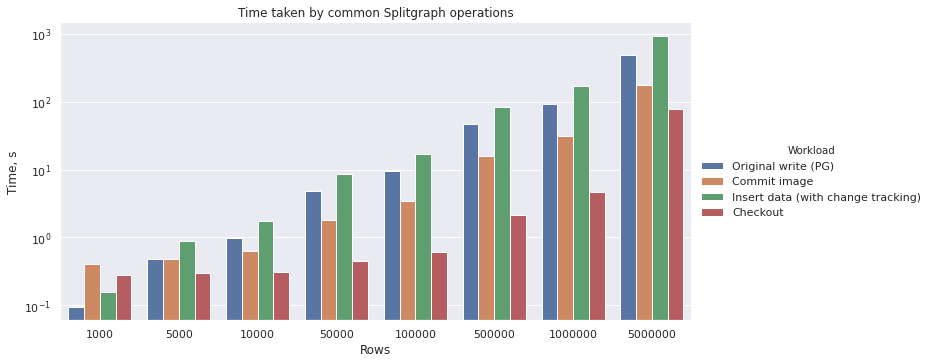

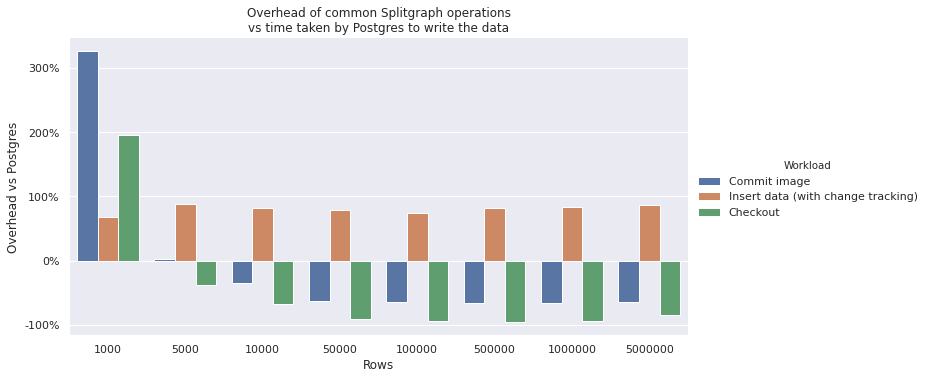

In [8]:
# Plot actual times
time_df = pd.DataFrame()
time_df["Rows"] = results_df["rows"]
time_df["Original write (PG)"] = results_df["table_creation"]
time_df["Commit image"] = results_df["commit_snap"]
time_df["Insert data (with change tracking)"] = results_df["insert_rows_change_tracking"]
time_df["Checkout"] = results_df["checkout"]

time_df = pd.melt(time_df, id_vars="Rows", var_name="Workload", value_name="Time, s")

sns.catplot(data=time_df, x="Rows", y="Time, s", 
                 hue="Workload", kind="bar", height=5, aspect=2)
plt.yscale("log")
plt.title("Time taken by common Splitgraph operations")

# Calculate the time overhead relative to Postgres
overhead_df = pd.DataFrame()
overhead_df["Rows"] = results_df["rows"]
overhead_df["Commit image"] = (results_df["commit_snap"] / results_df["table_creation"] - 1) * 100
overhead_df["Insert data (with change tracking)"] = (results_df["insert_rows_change_tracking"] / results_df["table_creation"] - 1) * 100
overhead_df["Checkout"] = (results_df["checkout"] / results_df["table_creation"] - 1) * 100

overhead_df = pd.melt(overhead_df, id_vars="Rows", var_name="Workload", value_name="Overhead vs Postgres")

sns.catplot(data=overhead_df, x="Rows", y="Overhead vs Postgres", 
                 hue="Workload", kind="bar", height=5, aspect=2)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Overhead of common Splitgraph operations\nvs time taken by Postgres to write the data")

For decently large (more than 1000 rows) tables, Splitgraph's commits and checkouts take a considerably smaller time than writing the initial table. This is for two reasons:

  * Writing the original table also takes into account the time to write and parse the INSERT statements. Splitgraph's commits and checkouts defer to Postgres for moving data around and don't actually inspect the data (apart from object hashing), avoiding this step.
  * Postgres' WAL and durability guarantees were enabled when the data was originally written. At commit time, writes to Splitgraph's `cstore_fdw` object files don't get reflected in the WAL (since `cstore_fdw` is implemented as a foreign table). Since the data is already in a PostgreSQL table, this is an acceptable tradeoff -- if the commit gets abruptly terminated, Splitgraph will restart it from scratch. Splitgraph itself doesn't commit its own metadata writes to PostgreSQL until after the image has been created.

Inserting data to a table with change tracking enabled incurs a slighly smaller than 1x overhead. This is because besides the actual target table, all writes have to be recorded to the pending changes table by the audit trigger.

Text(0.5, 1.0, 'Splitgraph vs PostgreSQL relative data sizes')

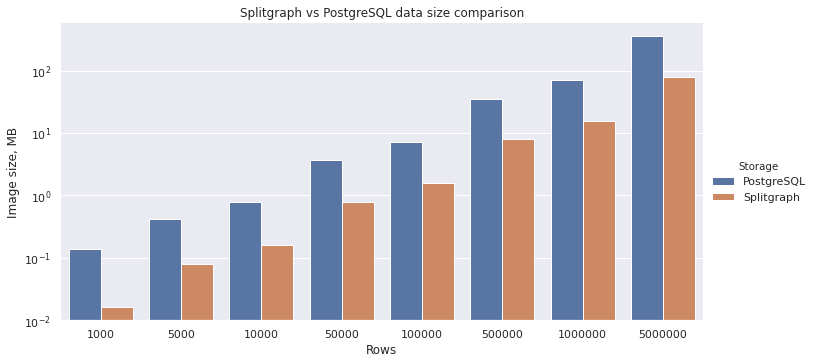

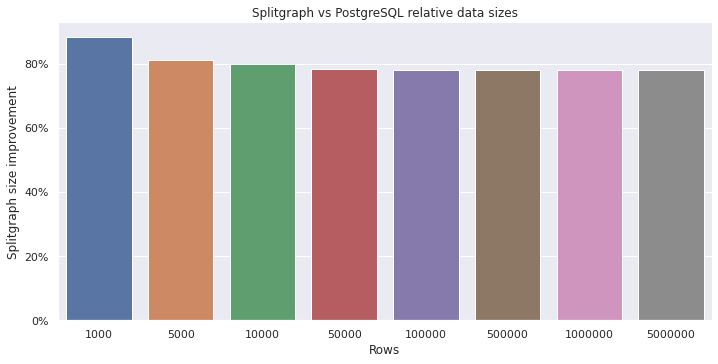

In [9]:
# Plot image sizes
size_df = pd.DataFrame()
size_df["Rows"] = results_df["rows"]
size_df["PostgreSQL"] = results_df["pg_size"] / 1024. / 1024.
size_df["Splitgraph"] = results_df["sg_size"] / 1024. / 1024.

size_df = pd.melt(size_df, id_vars="Rows", var_name="Storage", value_name="Image size, MB")

sns.catplot(data=size_df, x="Rows", y="Image size, MB", 
                 hue="Storage", kind="bar", height=5, aspect=2)
plt.yscale("log")
plt.title("Splitgraph vs PostgreSQL data size comparison")

# Plot image size overhead
size_df = pd.DataFrame()
size_df["Rows"] = results_df["rows"]
size_df["Splitgraph size improvement"] = (1 - results_df["sg_size"] / results_df["pg_size"]) * 100

sns.catplot(data=size_df, x="Rows", y="Splitgraph size improvement", kind="bar", height=5, aspect=2)
plt.yscale("linear")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Splitgraph vs PostgreSQL relative data sizes")

Splitgraph is much more efficient than PostgreSQL at storing data: in this case, Splitgraph images take up 5x less space than PostgreSQL tables. This is because Splitgraph uses [`cstore_fdw`](https://github.com/citusdata/cstore_fdw), a columnar store extension for PostgreSQL. Data stored in such way compresses better, since it's more homogeneous.

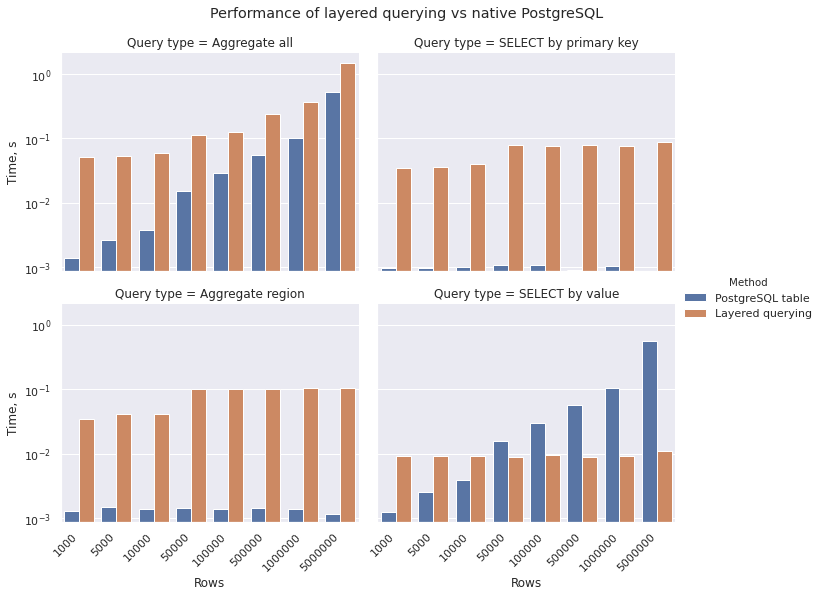

In [10]:
# Plot query performance.
query_df = pd.DataFrame()
query_df["Rows"] = results_df["rows"]
for query_short, query_name in [("select_all", "Aggregate all"), 
                                ("select_by_key", "SELECT by primary key"),
                                ("aggregate", "Aggregate region"),
                                ("select_by_value", "SELECT by value")]:
    query_df[f"{query_name} (PG)"] = results_df[f"{query_short}_pg"]
    query_df[f"{query_name} (LQ)"] = results_df[f"{query_short}_lq"]

query_df = pd.melt(query_df, id_vars=["Rows"], var_name="Query type", value_name="Time, s")
query_df["Method"] = query_df["Query type"].apply(lambda q: "PostgreSQL table" if "(PG)" in q else "Layered querying")
query_df["Query type"] = query_df["Query type"].apply(lambda q: q.replace(" (PG)", "").replace(" (LQ)", ""))

c = sns.catplot(data=query_df, x="Rows", y="Time, s", 
            hue="Method", col="Query type", kind="bar",
            height=4, aspect=1.2, col_wrap=2)
plt.yscale("log")
plt.subplots_adjust(top=0.90)
plt.suptitle("Performance of layered querying vs native PostgreSQL")
for axes in c.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment="right")

Splitgraph images can be queried in two ways: by checking them out into native PostgreSQL tables or by
querying them through a foreign data wrapper that presents itself to applications as a normal table (layered querying). These two methods have different tradeoffs and cover different use cases.

The query types here are:

  * Aggregate all: `SELECT AVG(value_2) FROM test`
  * SELECT by PK: `SELECT value_1 FROM test WHERE key = single_value`
  * Aggregate region: `SELECT AVG(value_2) FROM test WHERE key BETWEEN [a range of 1000 elements]`
  * SELECT by value: `SELECT 1 FROM test WHERE value_1 = '00000000'`

Layered querying usually incurs a fixed latency overhead, unlike PostgreSQL that can give an answer in less than a millisecond. This is because it's designed for querying huge datasets that are partially located on a remote machine: the LQ planner needs to consult Splitgraph's metadata store first to determine which objects need to be downloaded. This has an advantage over checking tables out: you don't need to download the whole dataset to run a query on it.

For a lot of use cases, querying native PostgreSQL tables is going to be the fastest in terms of performance, assuming you're OK with paying the one-off cost of checking them out and creating required indexes.

However, there is one notable outlier here: the "SELECT by value" query. Since it's not indexed in PostgreSQL, it forces a full table scan. Layered querying can use the Splitgraph range index on the objects' metadata to determine that none of the objects have this value and discard all of them.